In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [10]:
root_folder     = '/home/georgy/Documents/Dayan_lab/PhD/bandits/bandit/data/new/1/seqs/not_constrained/qvals_init'
analysis_folder = os.path.join(root_folder, 'analysis')
if not os.path.isdir(analysis_folder):
    os.mkdir(analysis_folder)

### Compare number of sequences and 1-step updates

In [11]:
xis        = np.logspace(np.log2(0.0001), np.log2(1.0), 11, base=2)
horizons   = [2, 3, 4, 5]
betas      = [1, 2, 4, 8]

big_matrix_prop = np.zeros((len(horizons), len(betas), len(xis)))
big_matrix_dir  = np.zeros_like(big_matrix_prop)

for hidx, horizon in enumerate(horizons):
                
        for bidx, beta in enumerate(betas):

            for xidx, xi in enumerate(xis):

                data = np.load(os.path.join(root_folder, 'replay_data', 'replays_%u_%u_%u.npy'%(hidx, bidx, xidx)), allow_pickle=True)
                # proportion of single-step and sequence replays

                num_fwd     = 0
                num_rev     = 0

                num_replays = len(data) - 1
                num_seqs    = 0
                for replay in data[1:]:
                    # whether it's a sequence
                    if len(replay[0]) > 1:
                        num_seqs += 1
                        # forward or reverse
                        if replay[0][0] > replay[0][1]:
                            num_rev += 1
                        else:
                            num_fwd += 1

                if num_replays > 0:
                    big_matrix_prop[hidx, bidx, xidx] = num_seqs/num_replays
                    if num_rev == 0:
                        big_matrix_dir[hidx, bidx, xidx] = 1
                    else:
                        big_matrix_dir[hidx, bidx, xidx]  = num_fwd/(num_rev + num_fwd)


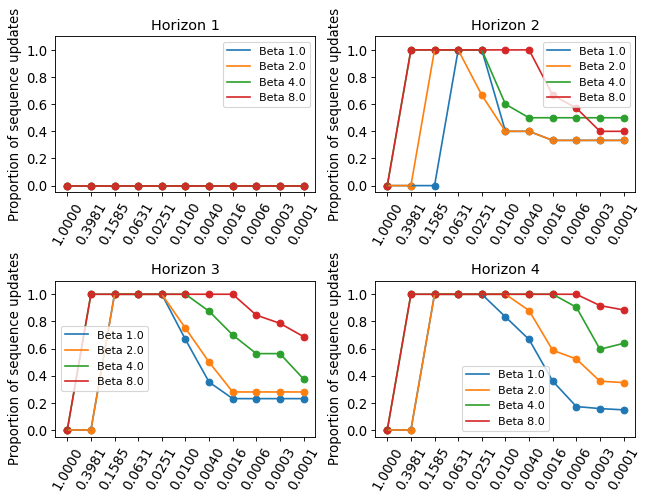

In [12]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True, dpi=80)

for hi in range(len(horizons)):
    plt.subplot(2, 2, hi+1)
    for bi in range(len(betas)):
        plt.plot(big_matrix_prop[hi, bi, ::-1], label='Beta %.1f'%betas[bi])
        plt.scatter(range(big_matrix_prop.shape[2]), big_matrix_prop[hi, bi, ::-1])
    plt.legend(prop={'size':10}, loc='best')
    plt.ylabel('Proportion of sequence updates', fontsize=12)
    plt.title('Horizon %u'%(hi+1), fontsize=13)
    plt.ylim(0-0.05, np.max(big_matrix_prop[:])+0.1)
    plt.yticks(fontsize=12)
    plt.xticks(range(big_matrix_prop.shape[2]), ['%.4f'%i for i in xis[::-1]], rotation=60, fontsize=12)

# plt.savefig(os.path.join(root_folder, 'analysis', 'single_vs_seq.png'))

### Compare forward and reverse sequences

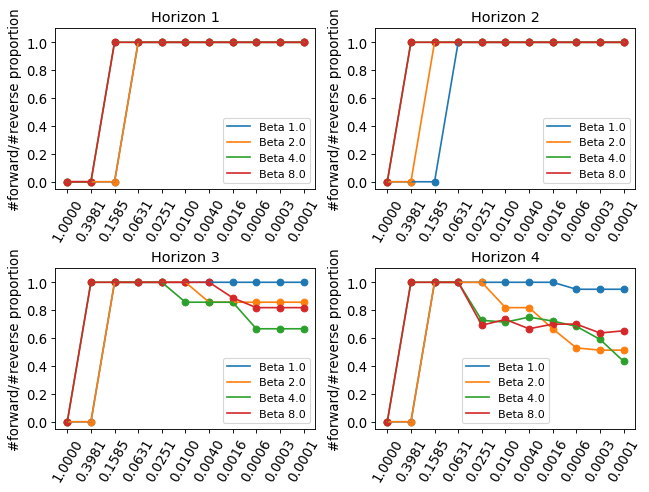

In [13]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True, dpi=80)

for hi in range(len(horizons)):
    plt.subplot(2, 2, hi+1)
    for bi in range(len(betas)):
        plt.plot(big_matrix_dir[hi, bi, ::-1], label='Beta %.1f'%betas[bi])
        plt.scatter(range(big_matrix_dir.shape[2]), big_matrix_dir[hi, bi, ::-1])
    plt.legend(prop={'size':10}, loc='best')
    plt.ylabel('#forward/#reverse proportion', fontsize=12)
    plt.title('Horizon %u'%(hi+1), fontsize=13)
    plt.ylim(0-0.05, np.max(big_matrix_dir[:])+0.1)
    plt.yticks(fontsize=12)
    plt.xticks(range(big_matrix_dir.shape[2]), ['%.4f'%i for i in xis[::-1]], rotation=60, fontsize=12)

# plt.savefig(os.path.join(root_folder, 'analysis', 'fwd_vs_rev.png'))

### Sequence composition

In [14]:
big_matrix = np.zeros((len(betas), len(xis), 4))
horizon    = 5
hidx       = 3
seqs       = np.zeros(horizon-2)

for bidx, beta in enumerate(betas):

    for xidx, xi in enumerate(xis):

        data = np.load(os.path.join(root_folder, 'replay_data', 'replays_%u_%u_%u.npy'%(hidx, bidx, xidx)), allow_pickle=True)
        # proportion of single-step and sequence replays

        for replay in data[1:]:
            # whether it's a sequence
            if len(replay[0]) == 1:
                big_matrix[bidx, xidx, 0] += 1
                num_seqs += 1
            elif len(replay[0]) == 2:
                big_matrix[bidx, xidx, 1] += 1
                num_seqs += 1
            elif len(replay[0]) == 3:
                big_matrix[bidx, xidx, 2] += 1
                num_seqs += 1
            elif len(replay[0]) == 4:
                big_matrix[bidx, xidx, 3] += 1
                num_seqs += 1

            # if np.sum(big_matrix[bidx, xidx, :]) > 0:
                # big_matrix[bidx, xidx, :] /= big_matrix[bidx, xidx, :].sum()

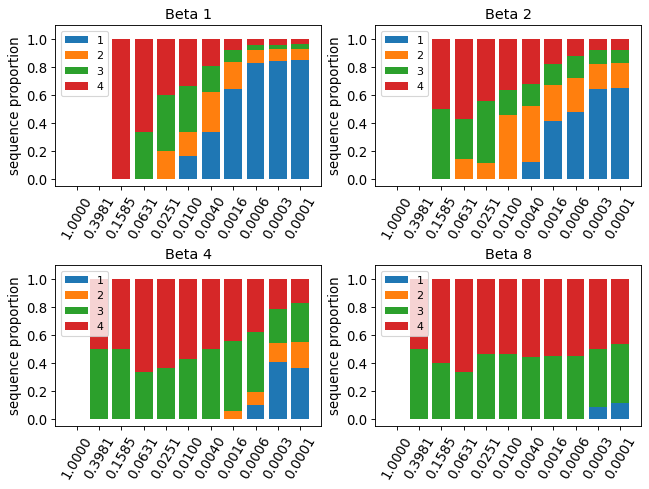

In [15]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True, dpi=80)

big_matrix_norm = big_matrix.copy()
for bidx, beta in enumerate(betas):
    for xidx, xi in enumerate(xis):
        if np.sum(big_matrix_norm[bidx, xidx, :]) > 0:
            big_matrix_norm[bidx, xidx, :] /= big_matrix_norm[bidx, xidx, :].sum()

for bidx in range(len(betas)):
    plt.subplot(2, 2, bidx+1)

    ones   = big_matrix_norm[bidx, ::-1, 0]
    twos   = big_matrix_norm[bidx, ::-1, 1]
    threes = big_matrix_norm[bidx, ::-1, 2]
    fours  = big_matrix_norm[bidx, ::-1, 3]

    plt.bar(range(len(xis)), ones, label='1')
    plt.bar(range(len(xis)), twos, bottom=ones, label='2')
    plt.bar(range(len(xis)), threes, bottom=ones+twos, label='3')
    plt.bar(range(len(xis)), fours, bottom=ones+twos+threes, label='4')

    plt.legend(prop={'size':10}, loc='best')
    plt.ylabel('sequence proportion', fontsize=12)
    plt.title('Beta %u'%(betas[bidx]), fontsize=13)
    plt.ylim(0-0.05, 1+0.1)
    plt.yticks(fontsize=12)
    plt.xticks(range(big_matrix_norm.shape[1]), ['%.4f'%i for i in xis[::-1]], rotation=60, fontsize=12)

# plt.savefig(os.path.join(root_folder, 'analysis', 'seq_compos.png'))

### Compare number of replays in seq and noseq

In [16]:
noseq_root_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/bandit/data/new/1/noseqs/qvals_init'

noseq_big_matrix = np.zeros((len(betas), len(xis), 1))
horizon          = 5
hidx             = 3
seqs             = np.zeros(horizon-2)

for bidx, beta in enumerate(betas):

    for xidx, xi in enumerate(xis):

        data = np.load(os.path.join(noseq_root_folder, 'replay_data', 'replays_%u_%u_%u.npy'%(hidx, bidx, xidx)), allow_pickle=True)

        noseq_big_matrix[bidx, xidx, 0] = len(data[1:])

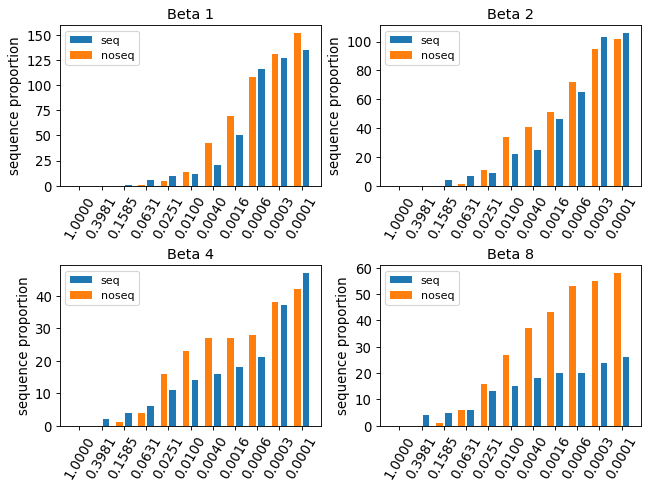

In [17]:
fig = plt.figure(figsize=(8, 6), constrained_layout=True, dpi=80)

for bidx in range(len(betas)):
    plt.subplot(2, 2, bidx+1)

    seq    = np.sum(big_matrix[bidx, ::-1, :], axis=1)
    noseq  = noseq_big_matrix[bidx, ::-1, 0]

    plt.bar(np.arange(len(xis))+0.2, seq, width=0.3, label='seq')
    plt.bar(np.arange(len(xis))-0.2, noseq, width=0.3, label='noseq')

    plt.legend(prop={'size':10}, loc='best')
    plt.ylabel('sequence proportion', fontsize=12)
    plt.title('Beta %u'%(betas[bidx]), fontsize=13)
    # plt.ylim(0-0.05, np.max(noseq_big_matrix[:]))
    plt.yticks(fontsize=12)
    plt.xticks(range(big_matrix.shape[1]), ['%.4f'%i for i in xis[::-1]], rotation=60, fontsize=12)

# plt.savefig(os.path.join(root_folder, 'analysis', 'seq_noseq_num.png'))